In [6]:
import requests
r = requests.get('https://ipinfo.io')
region = r.json()['region']
r.json()

{'city': 'The Dalles',
 'country': 'US',
 'hostname': '231.234.233.35.bc.googleusercontent.com',
 'ip': '35.233.234.231',
 'loc': '45.5946,-121.1787',
 'org': 'AS15169 Google LLC',
 'postal': '97058',
 'readme': 'https://ipinfo.io/missingauth',
 'region': 'Oregon',
 'timezone': 'America/Los_Angeles'}

In [8]:
!pip install pathy -q
!pip install wandb -q
!pip install -q git+https://github.com/huggingface/transformers.git timm
!pip install -q pytorch-lightning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [9]:
import argparse
from natsort import natsorted

parser = argparse.ArgumentParser(description='AG training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=16, type=int)
parser.add_argument('-lr', '--learning_rate', type=float, default=2e-4)
parser.add_argument('-t', '--train_steps', type=int, default=1000)
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP



### Sample local config
args = parser.parse_args('''
sketches
--train_dataset custom/train
--test_dataset custom/val
-c
-s GCS
--bucket_name lfp_europe_west4_a
'''.split())

### Sample local config
# args = parser.parse_args('''
# angles&rgb 
# --train_dataset rgb_ppt/train
# --test_dataset rgb_ppt/val
# -s LOCAL
# --bucket_name lfp_europe_west4_a
# '''.split())

In [10]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/artificial_graphics')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/artificial_graphics' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to artificial_graphics
os.chdir(WORKING_PATH)
import lib

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/artificial_graphics')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
fatal: destination path '/content/artificial_graphics' already exists and is not an empty directory.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading data from Google Cloud Storage
Storage path: gs://lfp_europe_west4_a/


## With Pytorch - we have to copy the data over


In [11]:
import subprocess
!mkdir data
!mkdir saved_models
subprocess.call(["gsutil", "-m", "cp", "-r", f"{TRAIN_DATA_PATHS[0]}", "data"])
subprocess.call(["gsutil", "-m", "cp", "-r", f"{TEST_DATA_PATHS[0]}", "data"])

0

## Create PyTorch dataset + dataloaders

Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrFeatureExtractor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [12]:
DATA_BASE = 'data/'

In [13]:
import torchvision
import os
import torch 

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        rotation = torch.as_tensor([a['rotation'] for a in target['annotations']])
        fill = torch.as_tensor([a['fill'] for a in target['annotations']])
        target = encoding["labels"][0] # remove batch dimension
        target['rotation'] = rotation
        target['fill'] = fill
        return pixel_values, target

In [14]:
# Based on the class defined above, we create training and validation datasets.
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{DATA_BASE}/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{DATA_BASE}/val', feature_extractor=feature_extractor, train=False)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [15]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 107
Number of validation examples: 19


Image n°7


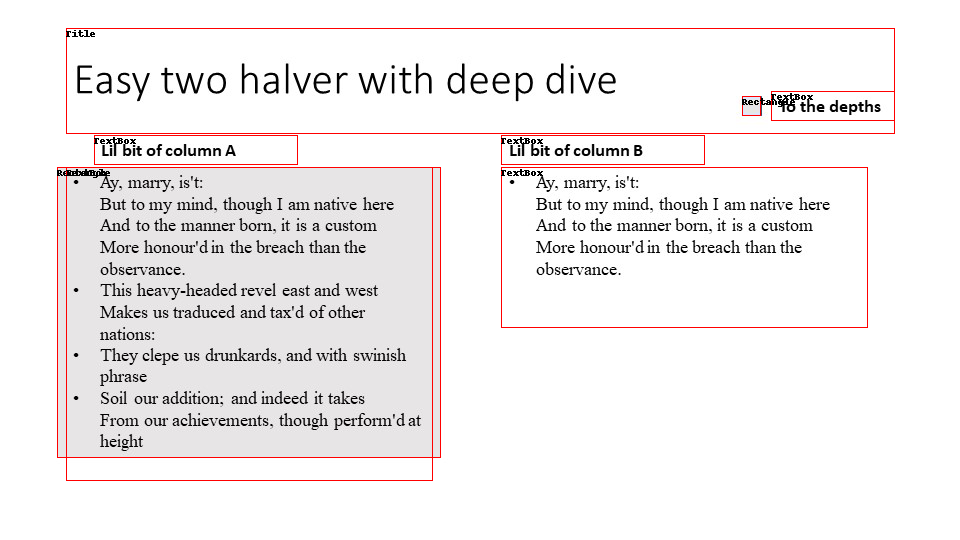

In [24]:
import numpy as np
import os
from PIL import Image, ImageDraw
import math

def makeRectangle(l, w, theta, offset=(0,0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0), (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x,y) in rectCoords]

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = val_dataset.coco.getImgIds()
# let's pick a random image
image_id =  image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{DATA_BASE}/val', image['file_name']))

annotations = val_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = val_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  #draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  v1,v2 = annotation['rotation']
  A  = np.arctan2(v2,v1)
  vertices = makeRectangle(w, h, A, offset=(x+w/2, y+h/2))  
  draw.polygon(vertices, outline='red')
  
  draw.text((vertices[2][0], vertices[2][1]), id2label[class_idx], fill='black')

image

In [25]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers = 3)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers = 3)
t_it = iter(train_dataloader)
batch = next(t_it)

In [26]:
# batch = next(t_it)
# import matplotlib.pyplot as plt
# for i in range(0,4):
#     plt.imshow(batch['pixel_values'][i].permute(1,2,0))
#     plt.show()

In [27]:
import lib
import lib.DETR

In [28]:
!git pull

Already up to date.


In [29]:
from importlib import reload
reload(lib)
reload(lib.DETR)

<module 'lib.DETR' from '/content/artificial_graphics/lib/DETR.py'>

In [30]:
import wandb
wandb.init(project="artificial_graphics_v3")
wandb.run.name = args.run_name

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [31]:
import pytorch_lightning as pl
from transformers import DetrConfig
from lib.DETR import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
         state_dict = model.state_dict()
         # Remove class weights
         del state_dict["class_labels_classifier.weight"]
         del state_dict["class_labels_classifier.bias"]
         # define new model with custom class classifier
         config = DetrConfig.from_pretrained("facebook/detr-resnet-50", num_labels=len(id2label))
         model = DetrForObjectDetection(config)
         model.load_state_dict(state_dict, strict=False)
         self.model = model

         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        log_dict = {"train_" + k: v.item() for k,v in loss_dict.items()}   
        log_dict['train_loss'] = loss   
        # logs metrics for each training_step,
        # and the average across the epoch
        # self.log("training_loss", loss)
        # for k,v in loss_dict.items():
        #   self.log("train_" + k, v.item())
        wandb.log(log_dict, step=self.global_step)
        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx) 
        log_dict = {"validation_" + k: v.item() for k,v in loss_dict.items()}
        log_dict['validation_loss'] = loss    
        # self.log("validation_loss", loss)
        # for k,v in loss_dict.items():
        #   self.log("validation_" + k, v.item())
        wandb.log(log_dict, step=self.global_step)
        self.save()
        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

     def save(self):
        torch.save(self.model.state_dict(), f'saved_models/{args.run_name}')
        subprocess.call(["gsutil", "-m", "cp", "-r", "saved_models/", str(STORAGE_PATH),])

     def load(self):
        state_dict = torch.load(f'saved_models/{args.run_name}', map_location=torch.device(self.device))
        model.load_state_dict(state_dict)

In [32]:
import subprocess 

def dld_model():
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
    command = ["gsutil", "cp", str(STORAGE_PATH/f'saved_models/{args.run_name}'), "saved_models/"]
    
    try:
        subprocess.call(command)
    except:
        print("try this:  ", " ".join(command))



In [33]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized: ['rotation_predictor.layers.0.bias', 'rotation_predictor.layers.1.weight', 'fill_predictor.layers.1.weight', 'fill_predictor.layers.0.bias', 'rotation_predictor.layers.1.bias', 'fill_predictor.layers.1.bias', 'fill_predictor.layers.0.weight', 'rotation_predictor.layers.0.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  

In [34]:
from pytorch_lightning import Trainer

trainer = Trainer(gpus=1, max_steps=2000, gradient_clip_val=0.1)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


In [ ]:

trainer.fit(model)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.core.lightning:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.6 M
-------------------------------------------------
41.4 M    Trainable params
222 K     Non-trainable params
41.6 M    Total params
166.581   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:349: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f'Your {mode}_dataloader has `shuffle=True`, it is best practice to turn'


In [ ]:
!ls saved_models

dummy_run2


In [ ]:
!gsutil -m cp -r saved_models/ gs://lfp_europe_west4_a/

Copying file://saved_models/dummy_run2 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1/1 files][158.9 MiB/158.9 MiB] 100% Done                                    
Operation completed over 1 objects/158.9 MiB.                                    


0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# model.eval()

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrTimmConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (act2): ReLU(inplace=True)
                (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn3)

In [ ]:
pixel_values, target = val_dataset[20]
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)
# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)


torch.Size([1, 3, 750, 1333])


In [ ]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_predictions(image, outputs, threshold=0.5):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

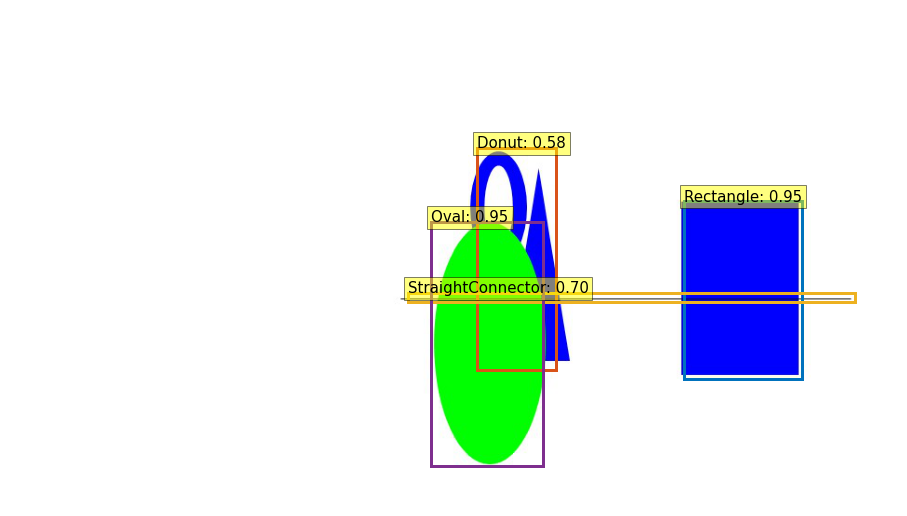

In [ ]:
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{DATA_BASE}/val', image['file_name']))

visualize_predictions(image, outputs)

In [ ]:
target['image_id']

tensor([6])